# Recurrent Neural Networks

## Import Pacakges

In [1]:
import tensorflow as tf
import torch
from torch import nn
from torch.utils import data
from torch.autograd import Variable

import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

plt.rcParams["figure.figsize"] = (8, 8)

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print(torch.__version__)

1.8.0


* https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html
* https://www.tensorflow.org/tutorials/structured_data/time_series
* https://d2l.ai/chapter_recurrent-neural-networks/sequence.html
* https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://towardsdatascience.com/all-you-need-to-know-about-rnns-e514f0b00c7c

## Global Variables

In [180]:
LEARNING_RATE = 0.03
NUM_EPOCHS = 70
BATCH_SIZE = 64
INIT_STDDEV = 0.01 # model weights - random initialisation from normal distribution
NUM_EXAMPLES = 100
BASE_COLORS = list(plt.cm.colors.BASE_COLORS.keys())
HEAD_ROWS = 10

## Step by Step Run Through

In [171]:
def ohe_encode_str_seq(str_seq):
    """
    one-hot-encode a string sequence
    """
    seq_reshaped = np.array([char for char in str_seq]).reshape(-1, 1) 
    ohe_enc = OneHotEncoder()
    ohe_enc.fit(sequence)
    seq_ohe = ohe_enc.transform(seq_reshaped).toarray()
    return seq_ohe, ohe_enc

In [172]:
# sequence = 'abcabcabcabcabc'
str_seq = 'abbccabbcc' * 10
str_seq

'abbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbcc'

In [173]:
str_seq_ohe, ohe_enc = ohe_encode_str_seq(str_seq)

In [176]:
print(str_seq_ohe.shape)
str_seq_ohe[: HEAD_ROWS]

(100, 3)


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [145]:
# numeric example
t = np.arange(0, 20, 0.2)
# x0 = np.array([1, 2, 3, 2, 1, 1, 2, 3, 2, 1] * 10)
x0 = 10 * np.sin(t)
x1 = np.arange(NUM_EXAMPLES)
x2 = x0 + x1
num_seq = np.swapaxes(np.array((x0, x1, x2)), 0, 1)

In [177]:
num_seq[: HEAD_ROWS]

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.98669331,  1.        ,  2.98669331],
       [ 3.89418342,  2.        ,  5.89418342],
       [ 5.64642473,  3.        ,  8.64642473],
       [ 7.17356091,  4.        , 11.17356091],
       [ 8.41470985,  5.        , 13.41470985],
       [ 9.32039086,  6.        , 15.32039086],
       [ 9.8544973 ,  7.        , 16.8544973 ],
       [ 9.99573603,  8.        , 17.99573603],
       [ 9.73847631,  9.        , 18.73847631]])

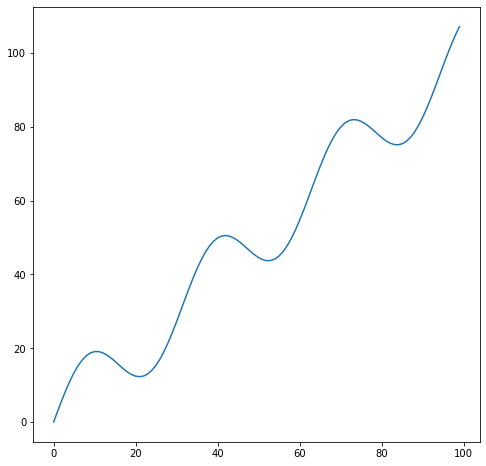

In [178]:
plt.plot(x2)

In [152]:
def get_ts_X_y(seq, batch_size, seq_len, n_features, output_idx=None, lookahead=1):
    """
    Split sequence into features X and label y so that it's ready to be trained
    if output_idx is None then we're predicting all indices of the output y 
    """
    X = np.zeros((batch_size, seq_len, n_features))
    y = np.zeros((batch_size, n_features))
    for i in range(batch_size):
        start_idx = np.random.choice(range(len(seq) - seq_len - lookahead))
        x_obs = seq[start_idx : start_idx + seq_len]
        y_obs = seq[start_idx + seq_len + lookahead]
        X[i] = x_obs
        y[i] = y_obs
    if output_idx is not None:
        y = y[:, output_idx]
    print(X.shape, y.shape)
    return X, y

In [179]:
n_features = len(num_seq[0])
seq_len = 15
X, y = get_ts_X_y(num_seq, BATCH_SIZE, seq_len, n_features, output_idx=2)

(64, 15, 3) (64,)


In [156]:
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)),
#     tf.keras.layers.Dense(n_features, activation=tf.nn.softmax)
# ])

In [157]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_len, n_features)),
    tf.keras.layers.Dense(1)
])

In [158]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                10800     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [159]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [160]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

For tf.keras.layers.LSTM model we need inputs with shape `[batch_size, n_timesteps, n_features]`

In [161]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(X, y, epochs=NUM_EPOCHS, verbose=1, callbacks=[])

Epoch 1/100


2022-05-13 20:58:02.699262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 165ms/step - loss: 3903.8635 - accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 168ms/step - loss: 3311.2126 - accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 174ms/step - loss: 2799.4602 - accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 172ms/step - loss: 2373.4917 - accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 167ms/step - loss: 1837.9104 - accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 156ms/step - loss: 1270.1189 - accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 169ms/step - loss: 424.5142 - accuracy: 0.0000e+00
Epoch 8/100
2/2 [==============================] - 0s 169ms/step - loss: 804.1145 - accuracy: 0.0000e+00
Epoch 9/100
2/2 [==============================] - 0s 170ms/step - loss: 155.3326 - accuracy: 0.0000e+00
Epoch 10/100
2/2 [==============================] - 0s 146ms/

In [166]:
test_data = X # X[0].reshape(-1, n_steps, n_features)
y_pred = model.predict(test_data, verbose=1)
y_pred.round(1)[:20]

2/2 [==============================] - 0s 28ms/step


array([[85.2],
       [54.2],
       [89.6],
       [85.2],
       [26.1],
       [39.1],
       [17.7],
       [40.2],
       [45.1],
       [70.9],
       [29.4],
       [49.4],
       [29.4],
       [50.7],
       [79.9],
       [58. ],
       [92.5],
       [84.9],
       [80.9],
       [61.3]], dtype=float32)

In [167]:
y[:20]

array([85., 55., 90., 85., 26., 40., 18., 40., 45., 70., 30., 50., 30.,
       50., 80., 58., 93., 85., 81., 60.])